# 1 Подготовка

## Импорт библиотек

In [ ]:
import os
import pickle
import requests
import zipfile

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## Устанавливаем стиль визуализации

In [33]:
sns.set_theme(style="whitegrid")

# 2 Загрузка данных

In [34]:
# Загрузка данных локально
file_path = '../data/tickets.csv'

data = pd.read_csv(file_path, delimiter=';')

In [ ]:
# Загрузка данных из внешнего хранилища
url = "https://www.kaggle.com/api/v1/datasets/download/adisongoh/it-service-ticket-classification-dataset"  # Адрес для загрузки данных

# Скачивание архива
response = requests.get(url, stream=True)
if response.status_code == 200:
    temp_archive = "../data/temp_archive.zip"
    with open(temp_archive, 'wb') as f:
        f.write(response.content)
    print(f"Данные успешно загружены с {url}")
else:
    raise Exception(f"Ошибка при загрузке данных: {response.status_code} {response.reason}")

# Распаковка архива
extract_dir = '../data'
with zipfile.ZipFile(temp_archive, 'r') as zip_ref:
    file_list = zip_ref.namelist()
    csv_files = [file for file in file_list if file.endswith('.csv')]

    if len(csv_files) != 1:
        raise Exception(f"Ожидался один CSV-файл в архиве, но найдено {len(csv_files)} файлов: {csv_files}")
    
    extracted_path = os.path.join(extract_dir, csv_files[0])
    zip_ref.extract(csv_files[0], extract_dir)

extracted_path = os.path.join(extract_dir, csv_files[0])  # Путь к найденному файлу
print("Архив успешно распакован.")

# Очистка временных файлов
os.remove(temp_archive)
print("Временный архив удалён.")

# Загрузка данных в DataFrame
data = pd.read_csv(extracted_path, delimiter=',')

# Переименование колонок при необходимости
rename_mapping = {
    'Document': 'Description',
    'Topic_group': 'Type'
}
data.rename(columns=rename_mapping, inplace=True)

In [35]:
# Проверка корректной загрузки данных
print("Пример данных:")
display(data.head())

Пример данных:


,id,title,Type,Description
0,NBI-1061,Smart Task Suggestions for Pipelines,New Feature,Create a feature that suggests tasks for each ...
1,NBI-1092,[Investigate] Error on Large Dataset Imports,Bug,Imports of large datasets sometimes result in ...
2,NBI-1099,Customer invoice attachments missing,Bug,Attachments added to customer invoices are not...
3,NBI-1120,Advanced customer segmentation tools,New Feature,Build a segmentation tool for categorizing cus...
4,NBI-1205,Dynamic Role Templates,New Feature,Create dynamic role templates that administrat...


# 3 Исследовательский анализ данных

/var/folders/n3/rsjb96c1557grc5hrmy_br340000gn/T/ipykernel_49067/3130683446.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


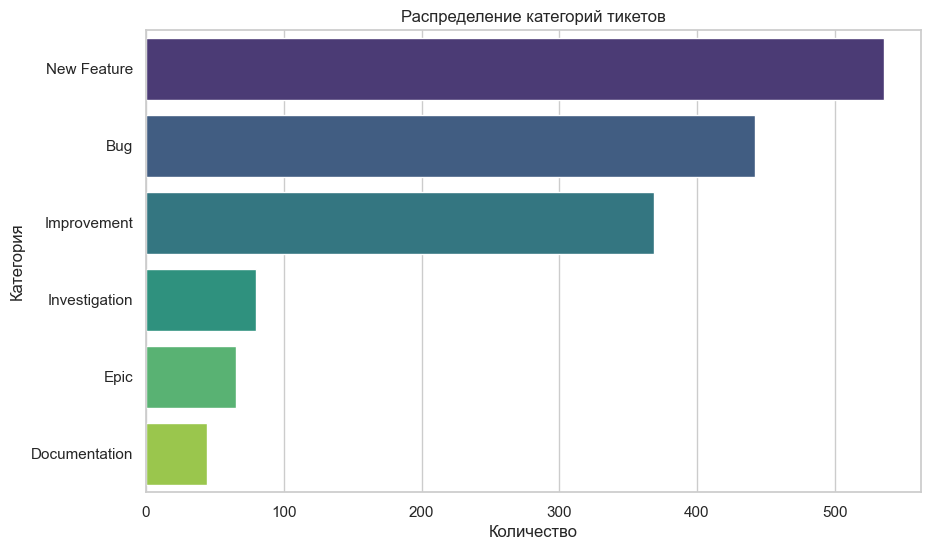

In [36]:
# Распределение категорий тикетов
plt.figure(figsize=(10, 6))
sns.countplot(
    y=data['Type'], 
    order=data['Type'].value_counts().index, 
    palette="viridis", 
    legend=False
)
plt.title('Распределение категорий тикетов')
plt.xlabel('Количество')
plt.ylabel('Категория')
plt.show()

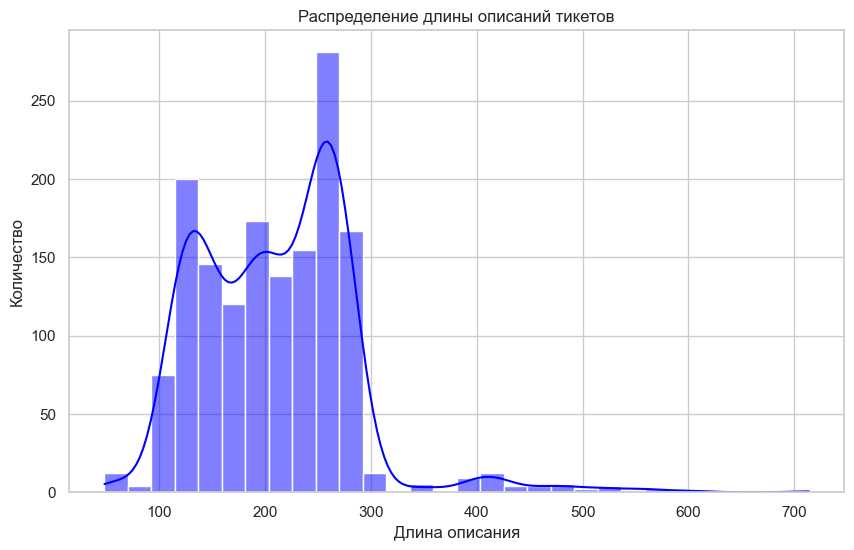

In [37]:
# Длина описаний тикетов
data['description_length'] = data['Description'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(
    data['description_length'], # Данные для визуализации (длина описаний тикетов)
    kde=True,
    bins=30,                    # Количество столбцов в гистограмме
    color='blue'
)
plt.title('Распределение длины описаний тикетов')
plt.xlabel('Длина описания')
plt.ylabel('Количество')
plt.show()

Топ униграмм:


/var/folders/n3/rsjb96c1557grc5hrmy_br340000gn/T/ipykernel_49067/1465096649.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=ngrams, palette='viridis')


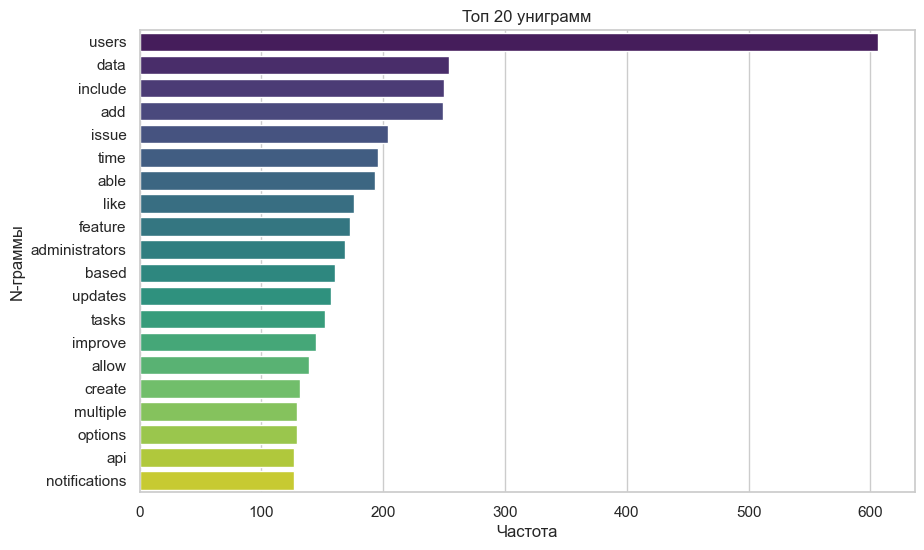

Топ биграмм:


/var/folders/n3/rsjb96c1557grc5hrmy_br340000gn/T/ipykernel_49067/1465096649.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=ngrams, palette='viridis')


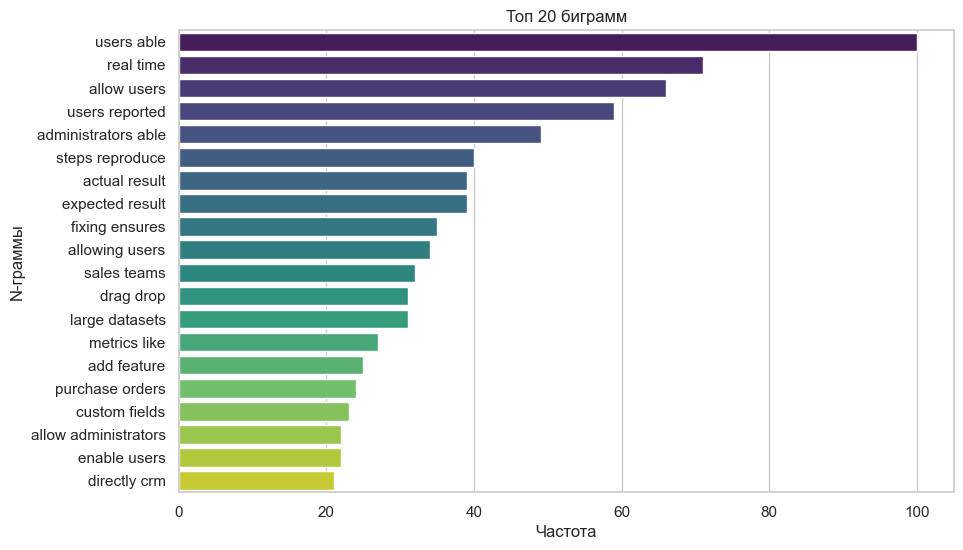

Топ триграмм:


/var/folders/n3/rsjb96c1557grc5hrmy_br340000gn/T/ipykernel_49067/1465096649.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=ngrams, palette='viridis')


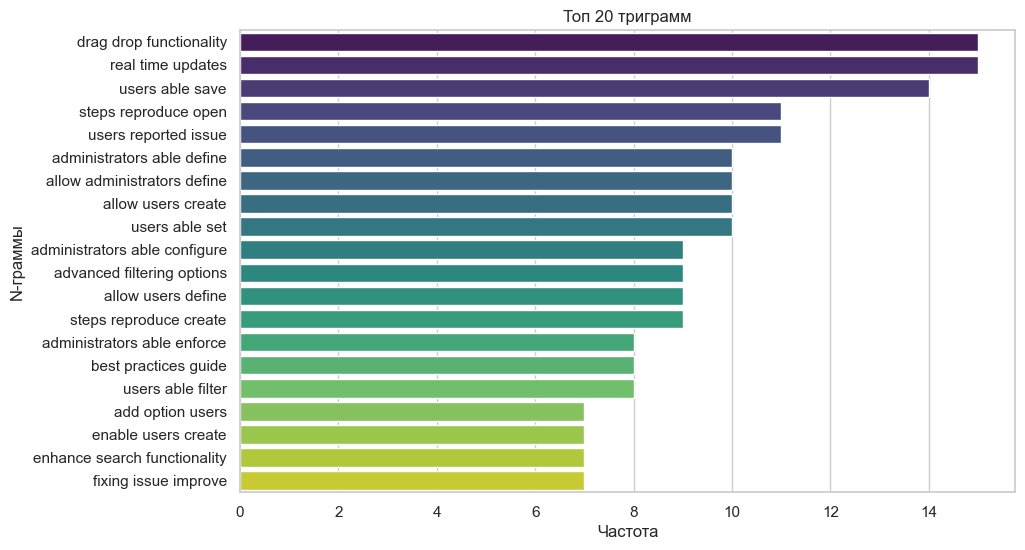

In [38]:
# Анализ и визуализация наиболее частых N-грамм

def plot_top_ngrams(corpus, ngram_range=(1, 1), top_n=20, title="Топ N-грамм"):
    vectorizer = CountVectorizer(
        ngram_range=ngram_range,  # Диапазон N-грамм
        stop_words='english'      # Исключение стоп-слов
    )
    X = vectorizer.fit_transform(corpus)
    
    # Подсчет частот N-грамм
    ngram_counts = Counter(
        dict(zip(
            vectorizer.get_feature_names_out(), # Список N-грамм
            X.sum(axis=0).A1                    # Сумма частот для каждой N-граммы
        ))
    )
    
    top_ngrams = ngram_counts.most_common(top_n)
    ngrams, counts = zip(*top_ngrams)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=ngrams, palette='viridis')
    plt.title(title)
    plt.xlabel('Частота')
    plt.ylabel('N-граммы')
    plt.show()

# Топ униграмм
print("Топ униграмм:")
plot_top_ngrams(data['Description'], ngram_range=(1, 1), top_n=20, title="Топ 20 униграмм")

# Топ биграмм
print("Топ биграмм:")
plot_top_ngrams(data['Description'], ngram_range=(2, 2), top_n=20, title="Топ 20 биграмм")

# Топ триграмм
print("Топ триграмм:")
plot_top_ngrams(data['Description'], ngram_range=(3, 3), top_n=20, title="Топ 20 триграмм")

# 4 Предобработка данных

In [39]:
# Удаляем строки с пропущенными значениями
data = data.dropna(subset=['Description', 'Type'])

In [40]:
# Приведение текста к нижнему регистру
data['Description'] = data['Description'].str.lower()

In [41]:
# Удаление лишних символов (шум)
data['Description'] = data['Description'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

In [42]:
# Выводим несколько обработанных записей
print("\nОбработанные данные:")
display(data.head())


Обработанные данные:


,id,title,Type,Description,description_length
0,NBI-1061,Smart Task Suggestions for Pipelines,New Feature,create a feature that suggests tasks for each ...,133
1,NBI-1092,[Investigate] Error on Large Dataset Imports,Bug,imports of large datasets sometimes result in ...,127
2,NBI-1099,Customer invoice attachments missing,Bug,attachments added to customer invoices are not...,256
3,NBI-1120,Advanced customer segmentation tools,New Feature,build a segmentation tool for categorizing cus...,282
4,NBI-1205,Dynamic Role Templates,New Feature,create dynamic role templates that administrat...,253


# 5 Разделение на признаки и целевые переменные, векторизация данных TF-IDF

In [43]:
X = data['Description']  # Признаки
y = data['Type']         # Целевая переменная

## Создание обучающей и валидационной выборки

In [44]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,                     # Признаки (в данном случае тексты тикетов)
    y,                     # Целевая переменная (категории тикетов)
    test_size=0.2,         # Доля данных, выделяемая для тестовой выборки (20%)
    random_state=42,       # Ключ для генерации случайных чисел
    stratify=y             # Стратификация для сохранения пропорций классов в выборках
)

print(f"\nКоличество записей в обучающей выборке: {len(X_train)}")
print(f"Количество записей в валидационной выборке: {len(X_test)}")


Количество записей в обучающей выборке: 1228
Количество записей в валидационной выборке: 308


In [45]:
# Векторизация текста
vectorizer = TfidfVectorizer(
    max_features=5000,       # Максимальное количество признаков
    stop_words='english',    # Удаление стандартных стоп-слов английского языка
    ngram_range=(1, 2)       # Учет униграмм (1 слово) и биграмм (2 последовательных слова)
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("\nРазмерность векторизованных данных:")
print(f"Обучающие данные: {X_train_tfidf.shape}")
print(f"Валидационные данные: {X_test_tfidf.shape}")


Размерность векторизованных данных:
Обучающие данные: (1228, 5000)
Валидационные данные: (308, 5000)


In [46]:
# Обработка дисбаланса классов

print("\nРаспределение классов до обработки дисбаланса:")
print(y.value_counts())

# Создание объекта SMOTE
smote = SMOTE(random_state=42)

# Применение oversampling только к обучающим данным
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)

print("\nРаспределение классов после применения SMOTE:")
print(pd.Series(y_resampled).value_counts())


Распределение классов до обработки дисбаланса:
Type
New Feature      536
Bug              442
Improvement      369
Investigation     80
Epic              65
Documentation     44
Name: count, dtype: int64

Распределение классов после применения SMOTE:
Type
Improvement      429
Epic             429
New Feature      429
Bug              429
Documentation    429
Investigation    429
Name: count, dtype: int64


/Users/ruslannigmatullin/ai-ticket-classifier/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/ruslannigmatullin/ai-ticket-classifier/venv/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


# 6 Обучение модели

### Логистическая регрессия

In [47]:
# Гиперпараметры для логистической регрессии
lr_param_grid = {
    'C': [0.1, 1, 10],                  # Коэффициент регуляризации
    'solver': ['lbfgs', 'liblinear']    # Алгоритмы оптимизации
}

# Инициализация GridSearchCV
grid_search_lr = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),  # Модель логистической регрессии с максимальным числом итераций 1000
    lr_param_grid,                                       # Гиперпараметры для перебора
    cv=3,                                                # Количество разбиений для кросс-валидации
    scoring='accuracy'                                   # Метрика для оценки
)

# Обучение модели и получение лучшей
grid_search_lr.fit(X_train_tfidf, y_train)
lr_model = grid_search_lr.best_estimator_

print(f"Лучшие параметры для Логистической регрессии: {grid_search_lr.best_params_}")

Лучшие параметры для Логистической регрессии: {'C': 10, 'solver': 'liblinear'}


### Метод K-ближайших соседей (KNN)

In [48]:
# Гиперпараметры для метода K-ближайших соседей (KNN)
knn_param_grid = {
    'n_neighbors': [3, 5, 7],           # Количество соседей для классификации
    'weights': ['uniform', 'distance']  # Веса соседей
}

# Инициализация GridSearchCV
grid_search_knn = GridSearchCV(
    KNeighborsClassifier(),         # Модель K-ближайших соседей
    knn_param_grid,                 # Гиперпараметры для перебора
    cv=3,                           # Количество разбиений для кросс-валидации
    scoring='accuracy'              # Метрика для оценки
)

# Обучение модели и получение лучшей
grid_search_knn.fit(X_train_tfidf, y_train)
knn_model = grid_search_knn.best_estimator_

print(f"Лучшие параметры для KNN: {grid_search_knn.best_params_}")

Лучшие параметры для KNN: {'n_neighbors': 7, 'weights': 'distance'}


### Метод случайного леса (Random Forest)

In [49]:
# Гиперпараметры для Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],  # Количество деревьев в лесу
    'max_depth': [None, 10, 20],      # Максимальная глубина деревьев
    'min_samples_split': [2, 5, 10]   # Минимальное количество образцов для разбиения узла
}

# Инициализация GridSearchCV
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),  # Классификатор Random Forest
    rf_param_grid,                            # Гиперпараметры для перебора
    cv=3,                                     # Количество разбиений кросс-валидации
    scoring='accuracy'                        # Метрика для оценки
)

# Обучение модели и получение лучшей
grid_search_rf.fit(X_train_tfidf, y_train)
rf_model = grid_search_rf.best_estimator_

print(f"Лучшие параметры для Random Forest: {grid_search_rf.best_params_}")

Лучшие параметры для Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}


### Метод опорных векторов (SVM)

In [50]:
# Гиперпараметры для метода опорных векторов (SVM)
svm_param_grid = {
    'C': [0.1, 1, 10],          # Коэффициент регуляризации
    'kernel': ['linear', 'rbf'] # Тип ядра для разделения
}

# Инициализация GridSearchCV
grid_search_svm = GridSearchCV(
    SVC(random_state=42),     # Классификатор SVM
    svm_param_grid,           # Гиперпараметры для перебора
    cv=3,                     # Количество разбиений кросс-валидации
    scoring='accuracy'        # Метрика для оценки
)

# Обучение модели и получение лучшей
grid_search_svm.fit(X_train_tfidf, y_train)
svm_model = grid_search_svm.best_estimator_

print(f"Лучшие параметры для SVM: {grid_search_svm.best_params_}")

Лучшие параметры для SVM: {'C': 10, 'kernel': 'linear'}


### Градиентный бустинг (Gradient Boosting)

In [51]:
# Гиперпараметры для градиентного бустинга
gb_param_grid = {
    'n_estimators': [50, 100, 200],     # Количество деревьев
    'learning_rate': [0.01, 0.1, 0.2],  # Скорость обучения
    'max_depth': [3, 5, 7]              # Максимальная глубина деревьев
}

# Инициализация GridSearchCV
grid_search_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42), # Классификатор Gradient Boosting
    gb_param_grid,                               # Гиперпараметры для перебора
    cv=3,                                        # Количество разбиений кросс-валидации
    scoring='accuracy'                           # Метрика для оценки
)

# Обучение модели и получение лучшей
grid_search_gb.fit(X_train_tfidf, y_train)
gb_model = grid_search_gb.best_estimator_

print(f"Лучшие параметры для градиентного бустинга: {grid_search_gb.best_params_}")

Лучшие параметры для градиентного бустинга: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}


# 7 Проверка работоспособности и оценка моделей

In [52]:
# Словарь для сохранения результатов
results = {}

results["Logistic Regression"] = {
    "accuracy": None,
    "classification_report": None
}

results["KNN"] = {
    "accuracy": None,
    "classification_report": None
}

results["Random Forest"] = {
    "accuracy": None,
    "classification_report": None
}

results["SVM"] = {
    "accuracy": None,
    "classification_report": None
}

results["Gradient Boosting"] = {
    "accuracy": None,
    "classification_report": None
}


Оценка модели: Логистическая регрессия
Accuracy для логистической регрессии: 0.8377
Отчёт по классификации для логистической регрессии:
               precision    recall  f1-score   support

          Bug       0.97      0.96      0.96        89
Documentation       1.00      0.89      0.94         9
         Epic       1.00      0.54      0.70        13
  Improvement       0.73      0.72      0.72        74
Investigation       1.00      0.88      0.93        16
  New Feature       0.77      0.85      0.81       107

     accuracy                           0.84       308
    macro avg       0.91      0.80      0.84       308
 weighted avg       0.84      0.84      0.84       308



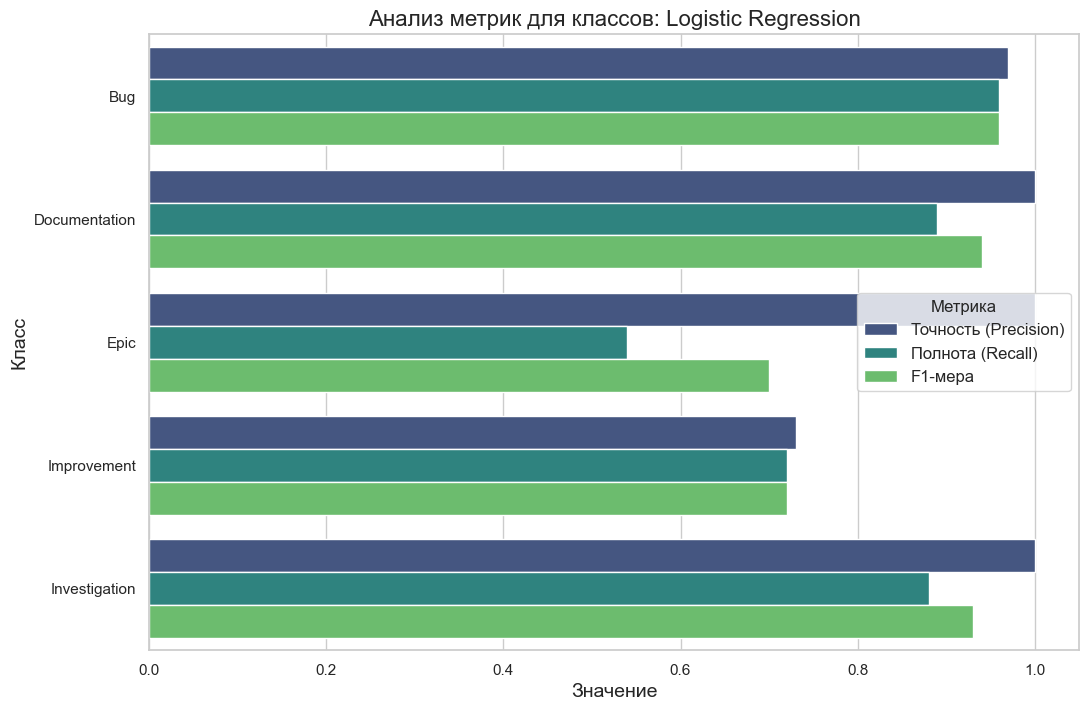

In [53]:
# Оценка логистической регрессии
lr_y_pred = lr_model.predict(X_test_tfidf)

print("\nОценка модели: Логистическая регрессия")
lr_accuracy = accuracy_score(y_test, lr_y_pred)
print(f"Accuracy для логистической регрессии: {lr_accuracy:.4f}")
lr_classification_rep = classification_report(y_test, lr_y_pred)
print("Отчёт по классификации для логистической регрессии:")
print(lr_classification_rep)
results["Logistic Regression"] = {
    "accuracy": lr_accuracy,
    "classification_report": lr_classification_rep
}

# Визуализация метрик
report_lines = lr_classification_rep.split('\n')
class_metrics = []

for line in report_lines:
    parts = line.split()
    if len(parts) >= 5 and parts[0] not in ["precision", "recall", "f1-score", "support", "accuracy"]:  
        try:
            class_name = parts[0]
            precision = float(parts[1])
            recall = float(parts[2])
            f1_score = float(parts[3])
            support = int(parts[4])
            class_metrics.append([class_name, precision, recall, f1_score, support])
        except ValueError:
            continue

class_metrics_df = pd.DataFrame(
    class_metrics,
    columns=["Класс", "Точность (Precision)", "Полнота (Recall)", "F1-мера", "Поддержка (Support)"]
)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=class_metrics_df.melt(id_vars="Класс", value_vars=["Точность (Precision)", "Полнота (Recall)", "F1-мера"]),
    x="value", y="Класс", hue="variable", palette="viridis"
)
plt.title("Анализ метрик для классов: Logistic Regression", fontsize=16)
plt.xlabel("Значение", fontsize=14)
plt.ylabel("Класс", fontsize=14)
plt.legend(title="Метрика", fontsize=12)
plt.show()


Оценка модели: K-ближайшие соседи (KNN)
Accuracy для KNN: 0.7175
Отчёт по классификации для KNN:
               precision    recall  f1-score   support

          Bug       0.81      0.83      0.82        89
Documentation       1.00      0.89      0.94         9
         Epic       1.00      0.38      0.56        13
  Improvement       0.58      0.57      0.57        74
Investigation       0.91      0.62      0.74        16
  New Feature       0.68      0.77      0.72       107

     accuracy                           0.72       308
    macro avg       0.83      0.68      0.73       308
 weighted avg       0.73      0.72      0.72       308



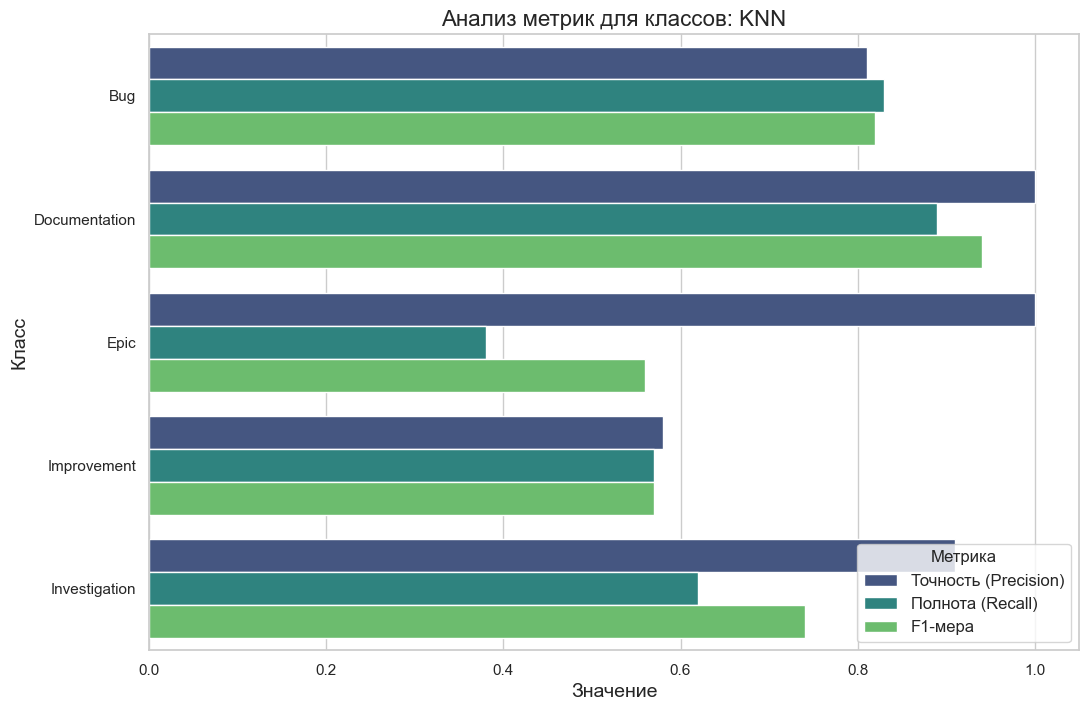

In [54]:
# Оценка K-ближайших соседей (KNN)
knn_y_pred = knn_model.predict(X_test_tfidf)

print("\nОценка модели: K-ближайшие соседи (KNN)")
knn_accuracy = accuracy_score(y_test, knn_y_pred)
print(f"Accuracy для KNN: {knn_accuracy:.4f}")
knn_classification_rep = classification_report(y_test, knn_y_pred)
print("Отчёт по классификации для KNN:")
print(knn_classification_rep)
results["KNN"] = {
    "accuracy": knn_accuracy,
    "classification_report": knn_classification_rep
}

# Визуализация метрик
report_lines = knn_classification_rep.split('\n')
class_metrics = []

for line in report_lines:
    parts = line.split()
    if len(parts) >= 5 and parts[0] not in ["precision", "recall", "f1-score", "support", "accuracy"]:  
        try:
            class_name = parts[0]
            precision = float(parts[1])
            recall = float(parts[2])
            f1_score = float(parts[3])
            support = int(parts[4])
            class_metrics.append([class_name, precision, recall, f1_score, support])
        except ValueError:
            continue

class_metrics_df = pd.DataFrame(
    class_metrics,
    columns=["Класс", "Точность (Precision)", "Полнота (Recall)", "F1-мера", "Поддержка (Support)"]
)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=class_metrics_df.melt(id_vars="Класс", value_vars=["Точность (Precision)", "Полнота (Recall)", "F1-мера"]),
    x="value", y="Класс", hue="variable", palette="viridis"
)
plt.title("Анализ метрик для классов: KNN", fontsize=16)
plt.xlabel("Значение", fontsize=14)
plt.ylabel("Класс", fontsize=14)
plt.legend(title="Метрика", fontsize=12)
plt.show()


Оценка модели: Случайный лес (Random Forest)
Accuracy для Random Forest: 0.8084
Отчёт по классификации для Random Forest:
               precision    recall  f1-score   support

          Bug       0.93      0.98      0.95        89
Documentation       0.89      0.89      0.89         9
         Epic       1.00      0.31      0.47        13
  Improvement       0.77      0.58      0.66        74
Investigation       0.91      0.62      0.74        16
  New Feature       0.72      0.91      0.80       107

     accuracy                           0.81       308
    macro avg       0.87      0.71      0.75       308
 weighted avg       0.82      0.81      0.80       308



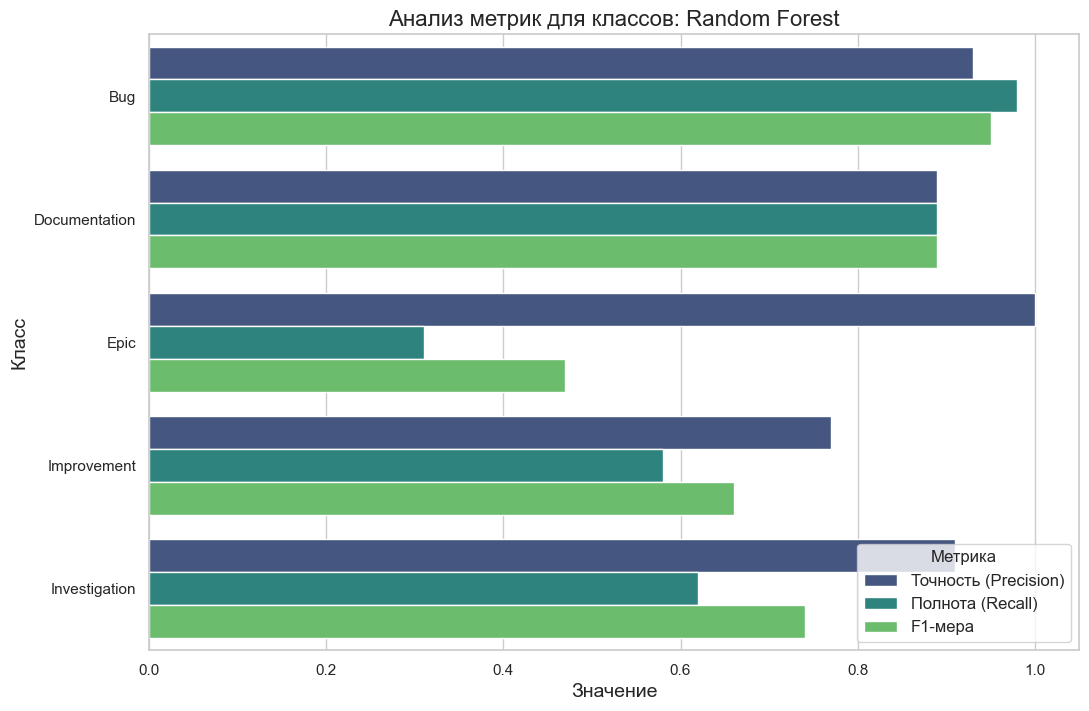

In [55]:
# Оценка случайного леса (Random Forest)
rf_y_pred = rf_model.predict(X_test_tfidf)

print("\nОценка модели: Случайный лес (Random Forest)")
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print(f"Accuracy для Random Forest: {rf_accuracy:.4f}")
rf_classification_rep = classification_report(y_test, rf_y_pred)
print("Отчёт по классификации для Random Forest:")
print(rf_classification_rep)
results["Random Forest"] = {
    "accuracy": rf_accuracy,
    "classification_report": rf_classification_rep
}

# Визуализация метрик
report_lines = rf_classification_rep.split('\n')
class_metrics = []

for line in report_lines:
    parts = line.split()
    if len(parts) >= 5 and parts[0] not in ["precision", "recall", "f1-score", "support", "accuracy"]:  
        try:
            class_name = parts[0]
            precision = float(parts[1])
            recall = float(parts[2])
            f1_score = float(parts[3])
            support = int(parts[4])
            class_metrics.append([class_name, precision, recall, f1_score, support])
        except ValueError:
            continue

class_metrics_df = pd.DataFrame(
    class_metrics,
    columns=["Класс", "Точность (Precision)", "Полнота (Recall)", "F1-мера", "Поддержка (Support)"]
)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=class_metrics_df.melt(id_vars="Класс", value_vars=["Точность (Precision)", "Полнота (Recall)", "F1-мера"]),
    x="value", y="Класс", hue="variable", palette="viridis"
)
plt.title("Анализ метрик для классов: Random Forest", fontsize=16)
plt.xlabel("Значение", fontsize=14)
plt.ylabel("Класс", fontsize=14)
plt.legend(title="Метрика", fontsize=12)
plt.show()


Оценка модели: Метод опорных векторов (SVM)
Accuracy для SVM: 0.8214
Отчёт по классификации для SVM:
               precision    recall  f1-score   support

          Bug       0.98      0.97      0.97        89
Documentation       0.89      0.89      0.89         9
         Epic       1.00      0.62      0.76        13
  Improvement       0.69      0.69      0.69        74
Investigation       1.00      0.88      0.93        16
  New Feature       0.75      0.80      0.77       107

     accuracy                           0.82       308
    macro avg       0.88      0.81      0.84       308
 weighted avg       0.83      0.82      0.82       308



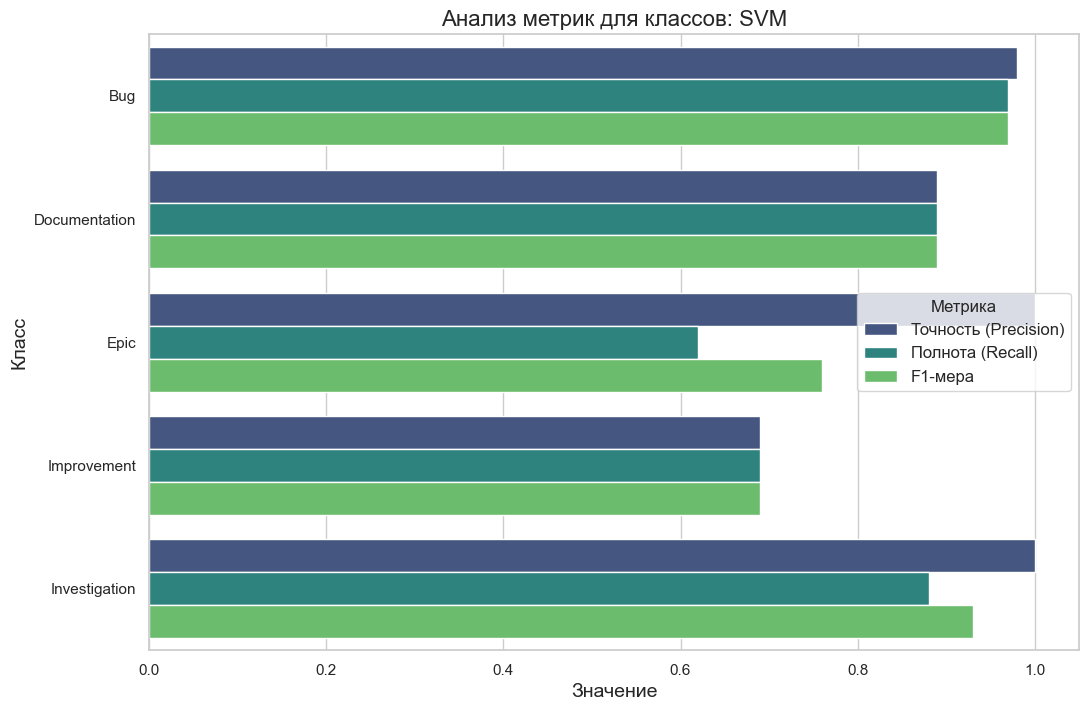

In [56]:
# Оценка метода опорных векторов (SVM)
svm_y_pred = svm_model.predict(X_test_tfidf)

print("\nОценка модели: Метод опорных векторов (SVM)")
svm_accuracy = accuracy_score(y_test, svm_y_pred)
print(f"Accuracy для SVM: {svm_accuracy:.4f}")
svm_classification_rep = classification_report(y_test, svm_y_pred)
print("Отчёт по классификации для SVM:")
print(svm_classification_rep)
results["SVM"] = {
    "accuracy": svm_accuracy,
    "classification_report": svm_classification_rep
}

# Визуализация метрик
report_lines = svm_classification_rep.split('\n')
class_metrics = []

for line in report_lines:
    parts = line.split()
    if len(parts) >= 5 and parts[0] not in ["precision", "recall", "f1-score", "support", "accuracy"]:  
        try:
            class_name = parts[0]
            precision = float(parts[1])
            recall = float(parts[2])
            f1_score = float(parts[3])
            support = int(parts[4])
            class_metrics.append([class_name, precision, recall, f1_score, support])
        except ValueError:
            continue

class_metrics_df = pd.DataFrame(
    class_metrics,
    columns=["Класс", "Точность (Precision)", "Полнота (Recall)", "F1-мера", "Поддержка (Support)"]
)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=class_metrics_df.melt(id_vars="Класс", value_vars=["Точность (Precision)", "Полнота (Recall)", "F1-мера"]),
    x="value", y="Класс", hue="variable", palette="viridis"
)
plt.title("Анализ метрик для классов: SVM", fontsize=16)
plt.xlabel("Значение", fontsize=14)
plt.ylabel("Класс", fontsize=14)
plt.legend(title="Метрика", fontsize=12)
plt.show()


Оценка модели: Градиентный бустинг (Gradient Boosting)
Accuracy для Gradient Boosting: 0.8149
Отчёт по классификации для Gradient Boosting:
               precision    recall  f1-score   support

          Bug       0.97      0.97      0.97        89
Documentation       0.67      0.89      0.76         9
         Epic       0.90      0.69      0.78        13
  Improvement       0.68      0.73      0.70        74
Investigation       0.91      0.62      0.74        16
  New Feature       0.79      0.79      0.79       107

     accuracy                           0.81       308
    macro avg       0.82      0.78      0.79       308
 weighted avg       0.82      0.81      0.82       308



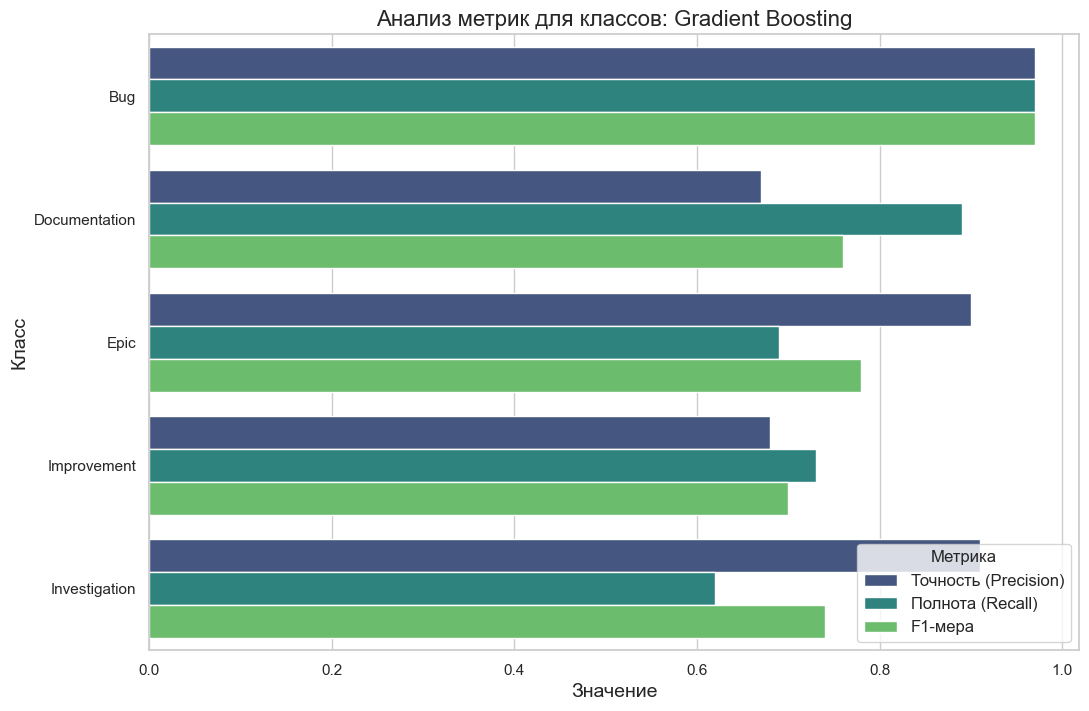

In [57]:
# Оценка градиентного бустинга (Gradient Boosting)
gb_y_pred = gb_model.predict(X_test_tfidf)

print("\nОценка модели: Градиентный бустинг (Gradient Boosting)")
gb_accuracy = accuracy_score(y_test, gb_y_pred)
print(f"Accuracy для Gradient Boosting: {gb_accuracy:.4f}")
gb_classification_rep = classification_report(y_test, gb_y_pred)
print("Отчёт по классификации для Gradient Boosting:")
print(gb_classification_rep)
results["Gradient Boosting"] = {
    "accuracy": gb_accuracy,
    "classification_report": gb_classification_rep
}

# Визуализация метрик
report_lines = gb_classification_rep.split('\n')
class_metrics = []

for line in report_lines:
    parts = line.split()
    if len(parts) >= 5 and parts[0] not in ["precision", "recall", "f1-score", "support", "accuracy"]:  
        try:
            class_name = parts[0]
            precision = float(parts[1])
            recall = float(parts[2])
            f1_score = float(parts[3])
            support = int(parts[4])
            class_metrics.append([class_name, precision, recall, f1_score, support])
        except ValueError:
            continue

# Создаём DataFrame
class_metrics_df = pd.DataFrame(
    class_metrics,
    columns=["Класс", "Точность (Precision)", "Полнота (Recall)", "F1-мера", "Поддержка (Support)"]
)

# Построение визуализации
plt.figure(figsize=(12, 8))
sns.barplot(
    data=class_metrics_df.melt(id_vars="Класс", value_vars=["Точность (Precision)", "Полнота (Recall)", "F1-мера"]),
    x="value", y="Класс", hue="variable", palette="viridis"
)
plt.title("Анализ метрик для классов: Gradient Boosting", fontsize=16)
plt.xlabel("Значение", fontsize=14)
plt.ylabel("Класс", fontsize=14)
plt.legend(title="Метрика", fontsize=12)
plt.show()


Сравнение результатов моделей:


/var/folders/n3/rsjb96c1557grc5hrmy_br340000gn/T/ipykernel_49067/2589791542.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='viridis')


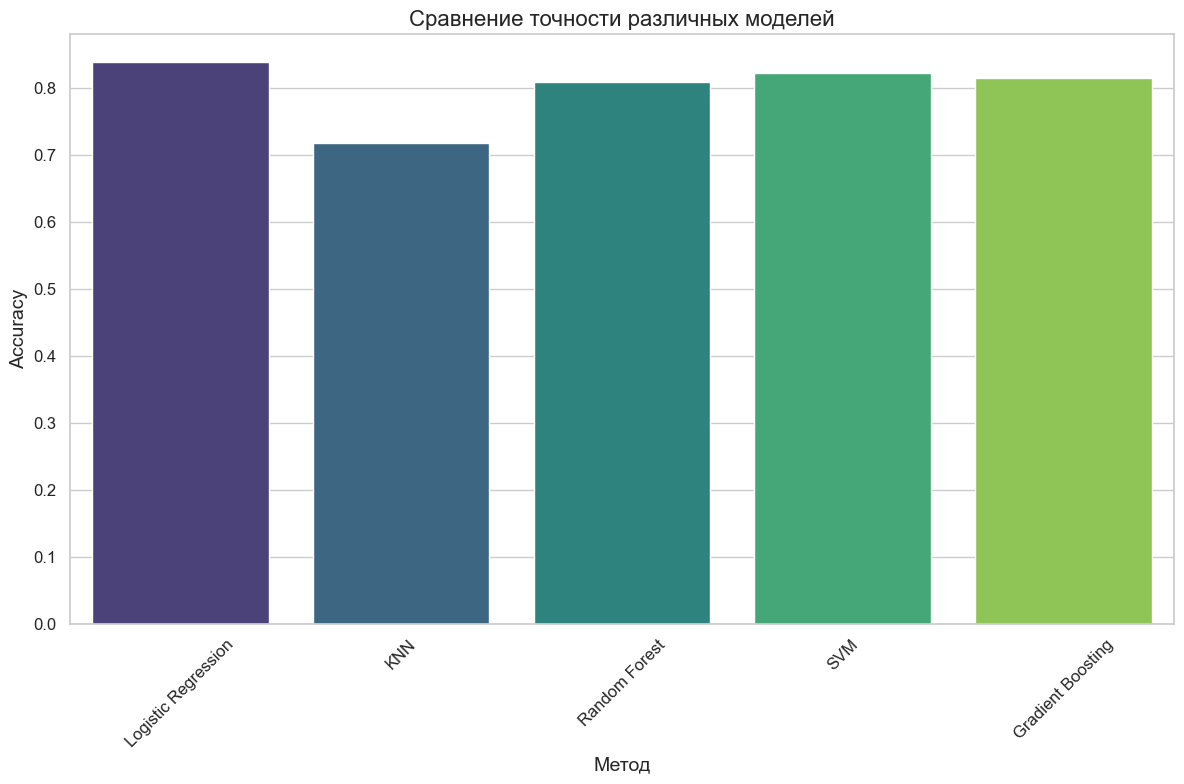


Подробные отчёты по классификации для каждой модели:


Модель: Logistic Regression
Accuracy: 0.8377
Отчет по классификации:
               precision    recall  f1-score   support

          Bug       0.97      0.96      0.96        89
Documentation       1.00      0.89      0.94         9
         Epic       1.00      0.54      0.70        13
  Improvement       0.73      0.72      0.72        74
Investigation       1.00      0.88      0.93        16
  New Feature       0.77      0.85      0.81       107

     accuracy                           0.84       308
    macro avg       0.91      0.80      0.84       308
 weighted avg       0.84      0.84      0.84       308


Модель: KNN
Accuracy: 0.7175
Отчет по классификации:
               precision    recall  f1-score   support

          Bug       0.81      0.83      0.82        89
Documentation       1.00      0.89      0.94         9
         Epic       1.00      0.38      0.56        13
  Improvement       0.58      0.57      0.57   

In [58]:
# Визуализация сравнительных результатов
print("\nСравнение результатов моделей:")
model_names = list(results.keys())
accuracies = [results[model]["accuracy"] for model in model_names]

# Построение графика точности
plt.figure(figsize=(12, 8))
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.title('Сравнение точности различных моделей', fontsize=16)
plt.xlabel('Метод', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Шаг 8: Печать всех отчётов классификации
print("\nПодробные отчёты по классификации для каждой модели:\n")
for model, metrics in results.items():
    print(f"\nМодель: {model}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print("Отчет по классификации:")
    print(metrics["classification_report"])

# 8 Сохранение модели

In [59]:
# Нахождение модель с наилучшей точностью
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model_accuracy = results[best_model_name]['accuracy']

print(f"Лучшей моделью оказалась: {best_model_name} с точностью {best_model_accuracy:.4f}")

# Сопоставление названия модели с её объектом
model_mapping = {
    "Logistic Regression": lr_model,
    "KNN": knn_model,
    "Random Forest": rf_model,
    "SVM": svm_model,
    "Gradient Boosting": gb_model
}

Лучшей моделью оказалась: Logistic Regression с точностью 0.8377


In [60]:
# Сохранение лучшей модели
best_model = model_mapping[best_model_name]
model_path = f"../models/{best_model_name.replace(' ', '_').lower()}_ticket_classifier_model.pkl"

with open(model_path, 'wb') as model_file:
    pickle.dump(best_model, model_file)

# Сохранение векторизатора
vectorizer_path = f"../models/{best_model_name.replace(' ', '_').lower()}_tfidf_vectorizer.pkl"

with open(vectorizer_path, 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

print(f"Модель '{best_model_name}' успешно сохранена по пути: {model_path}")
print(f"Векторизатор сохранён по пути: {vectorizer_path}")

Модель 'Logistic Regression' успешно сохранена по пути: ../models/logistic_regression_ticket_classifier_model.pkl
Векторизатор сохранён по пути: ../models/logistic_regression_tfidf_vectorizer.pkl


# 9 Загрузка и проверка модели

In [61]:
# Загрузка модели
with open(model_path, 'rb') as model_file:
    loaded_model = pickle.load(model_file)

# Загрузка векторизатора
with open(vectorizer_path, 'rb') as vectorizer_file:
    loaded_vectorizer = pickle.load(vectorizer_file)

print("\nМодель и векторизатор успешно загружены.")


Модель и векторизатор успешно загружены.


In [62]:
# Тестирование загруженной модели на новом тексте
new_ticket = ["Reports fail to load when certain filters are applied"]
new_ticket_vectorized = loaded_vectorizer.transform(new_ticket)
new_ticket_prediction = loaded_model.predict(new_ticket_vectorized)

print("\nТестовое описание тикета:", new_ticket[0])
print("Предсказанная категория:", new_ticket_prediction[0])


Тестовое описание тикета: Reports fail to load when certain filters are applied
Предсказанная категория: Bug
